# ENSAE - Sampling Methods Project | Experimenting with SVGD using the PyMC package and a comparison with Langevin

# 1. Introduction

## 1.1 General Remarks

We knew that we would like to experiment with SVGD. Following to that, we were thinking of a way how to do that. In the beginning, the following three libaries were up for discussion: PyMC, Stan, BlackJAX. However, it became visible quickly that BlackJAX was little and Stan barely suitable for that. On the other hand, PyMC offers a SVGD class as well as extensive documentation, allowing for rather simple utilization.

The following website contains explanations and tutorials that were helpful to get started with PyMC: https://www.pymc.io/projects/docs/en/latest/learn.html

This notebook contains... <span style="color:yellow">[HERE WE SHOULD ADD A SHORT SUMMARY OF WHAT WE ARE DOING]</span>


## 1.2 Installation and importing the libraries

To avoid issues with dependencies (that seem to be a thing), we created a new conda environment for this project. It is important to install pymc but also all the other libraries that are imported in the cell down below.

Please have a look at this link (https://www.pymc.io/projects/docs/en/latest/installation.html) to find out how to create and activate a new environment and how to install pymc. After doing so, it was necessary for us to create a new kernel with the ipykernel package (https://ipython.readthedocs.io/en/stable/install/kernel_install.html).

After installing everything, the required packages can be imported:

In [1]:
# import
import pymc as pm
from pymc import model_to_graphviz
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import scipy
import scipy.special
from sklearn.model_selection import train_test_split
from numpy.random import default_rng
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde

# 2. Artificial Data

## 2.1 Artificial Data - SVGD

Information on SVGD with can be found here: https://www.pymc.io/projects/docs/en/latest/api/generated/pymc.SVGD.html

Before using the breast cancer data set, let's try it out with artificial data.

In the following, the code just generates some artifical linear data and then defines a PyMC model with SVGD to fit the target distribution. In the end, the slope and intercept of 1000 samples is plotted.

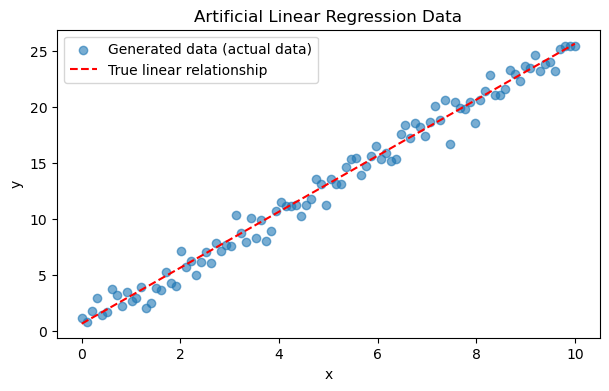

In [2]:
# Step 1: Generate Artificial Data
# We will create a simple linear regression dataset
np.random.seed(42)  # For reproducibility
x = np.linspace(0, 10, 100)  # 100 data points from 0 to 10
true_slope = 2.5
true_intercept = 0.65
# Generate noise
noise = np.random.normal(scale=1, size=len(x))
# Generate y values based on the linear model y = mx + c + noise
y = true_slope * x + true_intercept + noise

# Plotting the generated data
plt.figure(figsize=(7, 4))
plt.scatter(x, y, alpha=0.6, label='Generated data (actual data)')
plt.plot(x, true_slope * x + true_intercept, 'r--', label='True linear relationship')
plt.title('Artificial Linear Regression Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [3]:
# Step 2: Define the PyMC Model
# Here we define a Bayesian model with priors for slope and intercept, and a likelihood for observed data
with pm.Model() as model:
    # Priors for the unknown model parameters
    slope = pm.Normal('slope', mu=0, sigma=10)
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    # Likelihood (sampling distribution) of observations
    y_obs = pm.Normal('y_obs', mu=slope * x + intercept, sigma=0.5, observed=y)

    # Step 3: Set up SVGD
    # We use SVGD for Bayesian inference to approximate the posterior distribution of slope and intercept
    svgd = pm.SVGD(n_particles=100, jitter=0.1, model=model)

    # Step 4: Run SVGD
    # We perform the inference over 10,000 iterations to adjust particles to fit the target distribution
    approx = svgd.fit(500000)

Output()

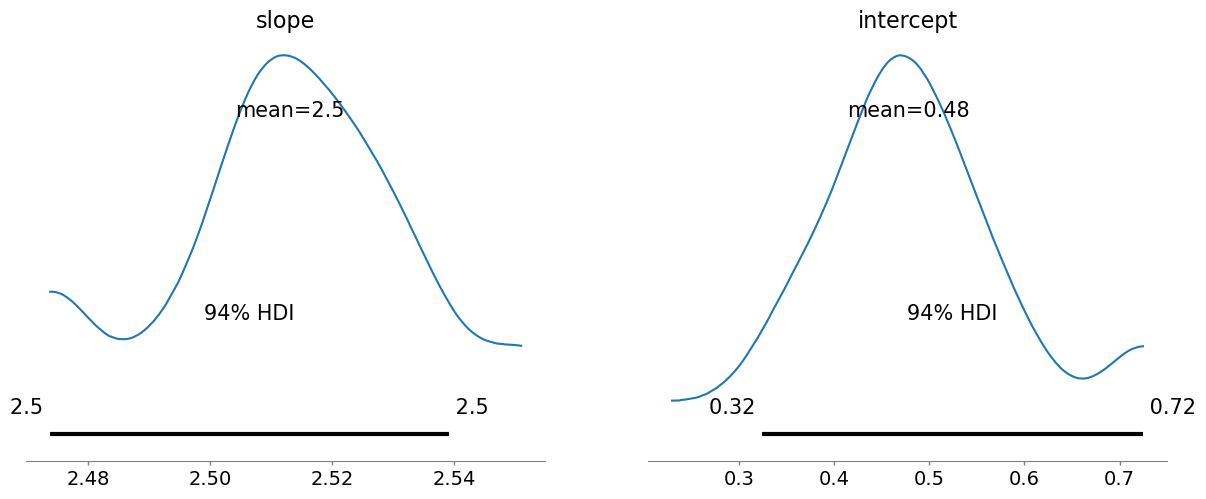

In [4]:
# Step 5: Sample from the Approximate Posterior
# samples from the distributions of slope and intercept
trace = approx.sample(100)

# Step 6: Visualize the Results
# plot the posterior distributions of the slope and the intercept
pm.plot_posterior(trace, var_names=['slope', 'intercept'])
plt.show()

This shows a KDE plot of the posterior distribution of the slope and the intercept. <span style="color:yellow">[DESCRIBE A BIT MORE IN DETAIL WHAT IT ACTUALLY MEANS]</span>.

### Sanity Checks and Summary Statistics

As a short "sanity check", we are calculating the RSME for the linear models. That means we are interested to check the difference between the real values and those predicted with the estimated slope and intercept.

In [5]:
# Extracting data for 'slope' and 'intercept'
slope_samples = trace.posterior["slope"].values
intercept_samples = trace.posterior["intercept"].values

# Generate predictions using the estimated slope and intercept
y_pred = np.mean(slope_samples) * x + np.mean(intercept_samples)

# Calculate RMSE
rmse = np.sqrt(np.mean((y - y_pred) ** 2))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.9027262108453609


Now we can also plot the y that is predicted with the posterior slope and intercept. For example, we can see that at x = 0, y_pred equals the posterior mean of the intercept (which is represented by the green line).

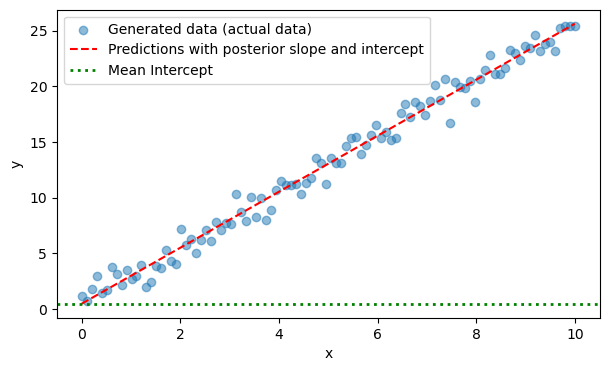

In [6]:
plt.figure(figsize=(7, 4))
plt.scatter(x, y, alpha=0.5, label='Generated data (actual data)')
plt.plot(x, y_pred, 'r--', label='Predictions with posterior slope and intercept')
plt.xlabel('x')
plt.ylabel('y')
plt.axhline(y=np.mean(intercept_samples), color='g', linestyle=':', linewidth=2, label='Mean Intercept')
plt.legend()
plt.show()

In [7]:
# This just creates a summary of the slope and intercept variable that was learned (using the arviz package)
az.summary(trace, round_to=2)

arviz - WARNING - Shape validation failed: input_shape: (1, 100), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.48,0.10,0.32,0.72,0.01,0.01,103.52,111.59,NaN
slope,2.51,0.02,2.47,2.54,0.00,0.00,98.83,112.14,NaN


To check the results from above, we calculate the mean and variance (standard deviation) manually.

The result is the same as with the az.summary() statistics.

In [8]:
# Extracting data for 'slope' and 'intercept'
slope_samples = trace.posterior["slope"].values
intercept_samples = trace.posterior["intercept"].values

# Calculate means and variances
slope_mean_svgd = np.mean(slope_samples)
intercept_mean_svgd = np.mean(intercept_samples)
slope_variance_svgd = np.var(slope_samples)
intercept_variance_svgd = np.var(intercept_samples)

print("Posterior Mean of Slope:", slope_mean_svgd)
print("Posterior Variance of Slope:", slope_variance_svgd)
print("Posterior Mean of Intercept:", intercept_mean_svgd)
print("Posterior Variance of Intercept:", intercept_variance_svgd)

# Calculate the standard deviation from the variance
slope_std_dev_svgd = np.sqrt(slope_variance_svgd)
intercept_std_dev_svgd = np.sqrt(intercept_variance_svgd)

print("Standard Deviation of Slope:", slope_std_dev_svgd)
print("Standard Deviation of Intercept:", intercept_std_dev_svgd)

Posterior Mean of Slope: 2.513145182736853
Posterior Variance of Slope: 0.000309870279643214
Posterior Mean of Intercept: 0.47791213137728283
Posterior Variance of Intercept: 0.009806353422737392
Standard Deviation of Slope: 0.017603132665614207
Standard Deviation of Intercept: 0.09902703379753122


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>]], dtype=object)

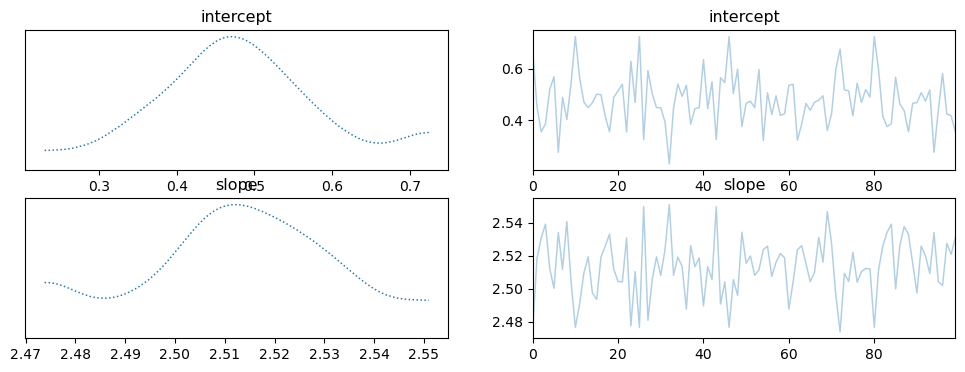

In [9]:
# The arviz package offers another way to plot both slope and intercept
az.plot_trace(trace, combined=True)

On the right side, we can see which slope and intercept has been samples at which point in time (in which order).

### Some experiments

#### Testing different numbers of iterations

First, we run the inference using SVGD with varying numbers of iterations. To be specific, we're using values from 1,000 to 20,000 and use a steps of 1,000. Then, we plot how the estimated means of slope and intercept change depending on the number of iterations used for the fitting.

Fitting model with 1000 iterations...


Output()

Fitting model with 2000 iterations...


Output()

Fitting model with 3000 iterations...


Output()

Fitting model with 4000 iterations...


Output()

Fitting model with 5000 iterations...


Output()

Fitting model with 6000 iterations...


Output()

Fitting model with 7000 iterations...


Output()

Fitting model with 8000 iterations...


Output()

Fitting model with 9000 iterations...


Output()

Fitting model with 10000 iterations...


Output()

Fitting model with 11000 iterations...


Output()

Fitting model with 12000 iterations...


Output()

Fitting model with 13000 iterations...


Output()

Fitting model with 14000 iterations...


Output()

Fitting model with 15000 iterations...


Output()

Fitting model with 16000 iterations...


Output()

Fitting model with 17000 iterations...


Output()

Fitting model with 18000 iterations...


Output()

Fitting model with 19000 iterations...


Output()

Fitting model with 20000 iterations...


Output()

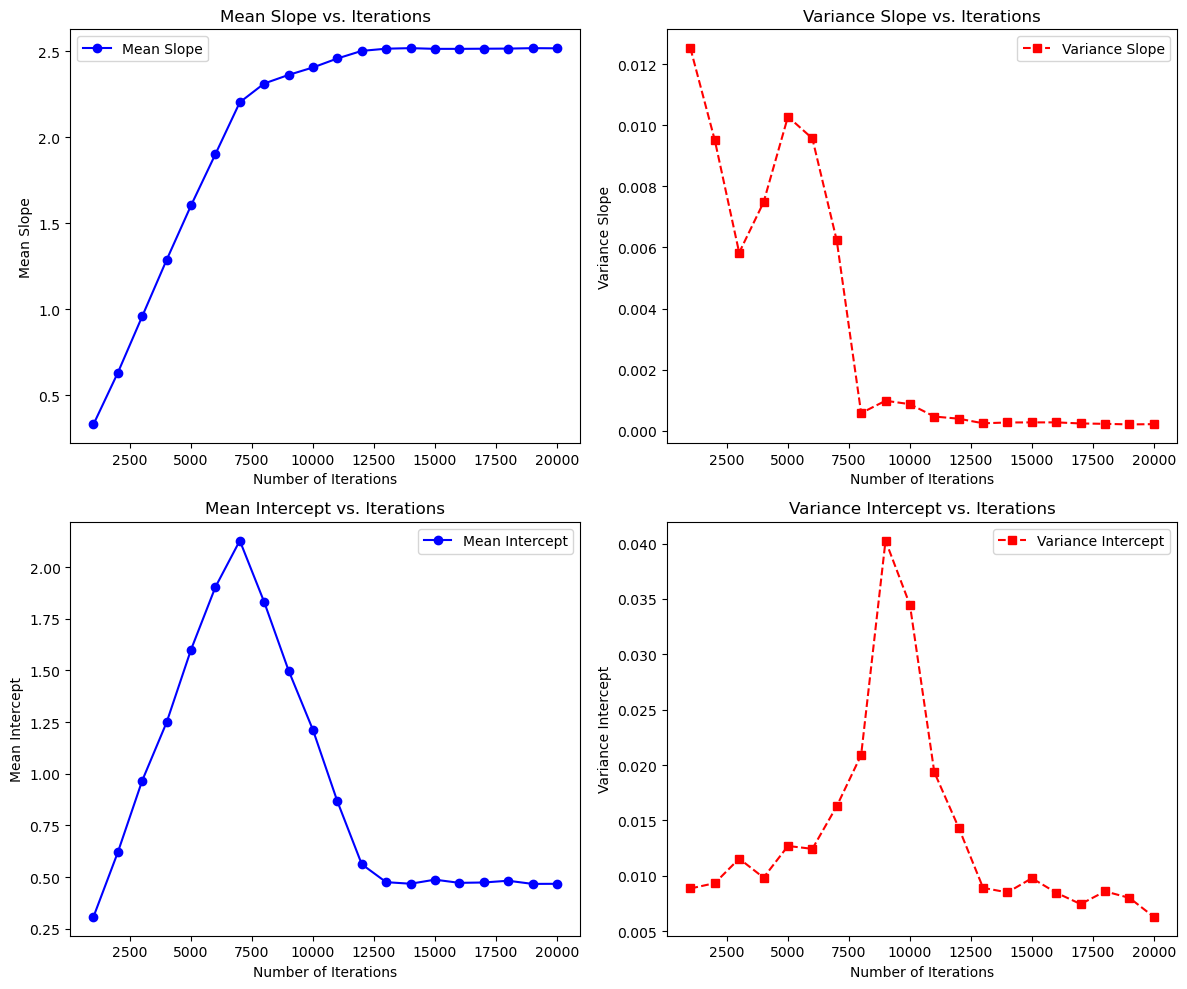

In [10]:
# Array of different iteration numbers to test
iterations_array = np.linspace(1000, 20000, 20).astype(int)

# Arrays to store results
slope_means = []
intercept_means = []
slope_variances = []
intercept_variances = []

# Perform inference for different numbers of iterations
for iterations in iterations_array:
    print(f"Fitting model with {iterations} iterations...")
    with model:
        # Setup SVGD
        svgd = pm.SVGD(n_particles=100, jitter=0.1)
        # Run SVGD
        approx = svgd.fit(iterations)
        # Sample from the approximate posterior
        trace = approx.sample(100)
        # Calculate and store means and variances
        slope_mean = np.mean(trace.posterior["slope"].values)
        intercept_mean = np.mean(trace.posterior["intercept"].values)
        slope_variance = np.var(trace.posterior["slope"].values)
        intercept_variance = np.var(trace.posterior["intercept"].values)

        slope_means.append(slope_mean)
        intercept_means.append(intercept_mean)
        slope_variances.append(slope_variance)
        intercept_variances.append(intercept_variance)

# Setting up the plot layout
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))  # 2x2 grid of subplots

# Plot Mean Slope
axes[0, 0].plot(iterations_array, slope_means, marker='o', linestyle='-', color='blue', label='Mean Slope')
axes[0, 0].set_title('Mean Slope vs. Iterations')
axes[0, 0].set_xlabel('Number of Iterations')
axes[0, 0].set_ylabel('Mean Slope')
axes[0, 0].legend()

# Plot Variance Slope
axes[0, 1].plot(iterations_array, slope_variances, marker='s', linestyle='--', color='red', label='Variance Slope')
axes[0, 1].set_title('Variance Slope vs. Iterations')
axes[0, 1].set_xlabel('Number of Iterations')
axes[0, 1].set_ylabel('Variance Slope')
axes[0, 1].legend()

# Plot Mean Intercept
axes[1, 0].plot(iterations_array, intercept_means, marker='o', linestyle='-', color='blue', label='Mean Intercept')
axes[1, 0].set_title('Mean Intercept vs. Iterations')
axes[1, 0].set_xlabel('Number of Iterations')
axes[1, 0].set_ylabel('Mean Intercept')
axes[1, 0].legend()

# Plot Variance Intercept
axes[1, 1].plot(iterations_array, intercept_variances, marker='s', linestyle='--', color='red', label='Variance Intercept')
axes[1, 1].set_title('Variance Intercept vs. Iterations')
axes[1, 1].set_xlabel('Number of Iterations')
axes[1, 1].set_ylabel('Variance Intercept')
axes[1, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

The diagram shows some interesting results. Letting the cell run multiple times has led to slightly different results. However, it could be seen that a number of around 12,000 (maybe 11,000 to 13,000) iterations was leading to somewhat stable results. The posterior variance of the intercept seems to be a bit of a difference as it continues to vary a little more than the others.

We also tried the same with a varying number of particles. However, no clear pattern or any convergence could be detected. (The following cell shows that but is hidden) There is reason to believe that this is due to the rather low number of generated data points (100). It would probably be necessary to increase the number of generated data points and utilized particles by a lot. However, this would increase the time necessary for fitting by a lot as well.

#### Testing different numbers of particles

Fitting model with 10 particles...


Output()

Fitting model with 20 particles...


Output()

Fitting model with 30 particles...


Output()

Fitting model with 40 particles...


Output()

Fitting model with 50 particles...


Output()

Fitting model with 60 particles...


Output()

Fitting model with 70 particles...


Output()

Fitting model with 80 particles...


Output()

Fitting model with 90 particles...


Output()

Fitting model with 100 particles...


Output()

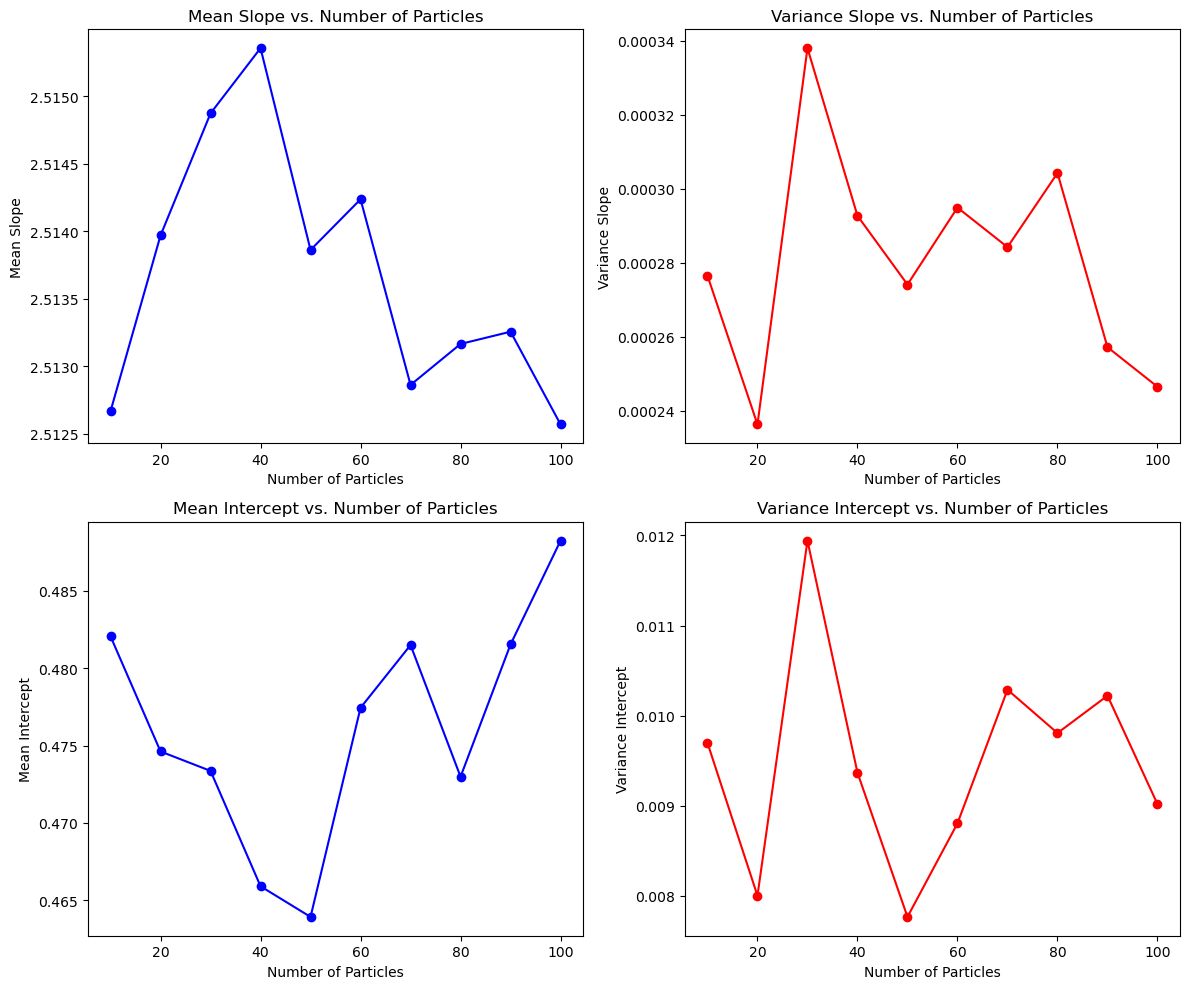

In [11]:
# Different numbers of particles to test
particle_array = np.linspace(10, 100, 10).astype(int)

# Arrays to store results
slope_means = []
intercept_means = []
slope_variances = []
intercept_variances = []

# Define the model
with pm.Model() as model:
    # Priors
    slope = pm.Normal('slope', mu=0, sigma=10)
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    # Likelihood
    y_obs = pm.Normal('y_obs', mu=slope * x + intercept, sigma=0.5, observed=y)

    # Loop over different numbers of particles
    for num_particles in particle_array:
        print(f"Fitting model with {num_particles} particles...")
        # Setup SVGD
        svgd = pm.SVGD(n_particles=num_particles, jitter=0.1)
        # Run SVGD
        approx = svgd.fit(13000)
        # Sample from the approximate posterior
        trace = approx.sample(100)
        # Calculate and store means and variances
        slope_mean = np.mean(trace.posterior["slope"].values)
        intercept_mean = np.mean(trace.posterior["intercept"].values)
        slope_variance = np.var(trace.posterior["slope"].values)
        intercept_variance = np.var(trace.posterior["intercept"].values)

        slope_means.append(slope_mean)
        intercept_means.append(intercept_mean)
        slope_variances.append(slope_variance)
        intercept_variances.append(intercept_variance)

# Plotting the results
plt.figure(figsize=(12, 10))

# Plot Mean Slope vs. Particles
plt.subplot(2, 2, 1)
plt.plot(particle_array, slope_means, marker='o', linestyle='-', color='blue')
plt.title('Mean Slope vs. Number of Particles')
plt.xlabel('Number of Particles')
plt.ylabel('Mean Slope')

# Plot Variance Slope vs. Particles
plt.subplot(2, 2, 2)
plt.plot(particle_array, slope_variances, marker='o', linestyle='-', color='red')
plt.title('Variance Slope vs. Number of Particles')
plt.xlabel('Number of Particles')
plt.ylabel('Variance Slope')

# Plot Mean Intercept vs. Particles
plt.subplot(2, 2, 3)
plt.plot(particle_array, intercept_means, marker='o', linestyle='-', color='blue')
plt.title('Mean Intercept vs. Number of Particles')
plt.xlabel('Number of Particles')
plt.ylabel('Mean Intercept')

# Plot Variance Intercept vs. Particles
plt.subplot(2, 2, 4)
plt.plot(particle_array, intercept_variances, marker='o', linestyle='-', color='red')
plt.title('Variance Intercept vs. Number of Particles')
plt.xlabel('Number of Particles')
plt.ylabel('Variance Intercept')

plt.tight_layout()
plt.show()


#### Testing different temperatures

Finally, we are trying out different "temperature" parameters. According to the PyMC documentation, this parameter is responsible for exploration. Higher temperature gives a more broad posterior estimate.

Fitting model with the temperature: 0.1


Output()

Fitting model with the temperature: 0.2


Output()

Fitting model with the temperature: 0.3


Output()

Fitting model with the temperature: 0.4


Output()

Fitting model with the temperature: 0.5


Output()

Fitting model with the temperature: 0.6


Output()

Fitting model with the temperature: 0.7


Output()

Fitting model with the temperature: 0.7999999999999999


Output()

Fitting model with the temperature: 0.8999999999999999


Output()

Fitting model with the temperature: 0.9999999999999999


Output()

Fitting model with the temperature: 1.0999999999999999


Output()

Fitting model with the temperature: 1.2


Output()

Fitting model with the temperature: 1.3


Output()

Fitting model with the temperature: 1.4


Output()

Fitting model with the temperature: 1.5


Output()

Fitting model with the temperature: 1.5999999999999999


Output()

Fitting model with the temperature: 1.7


Output()

Fitting model with the temperature: 1.8


Output()

Fitting model with the temperature: 1.9


Output()

Fitting model with the temperature: 2.0


Output()

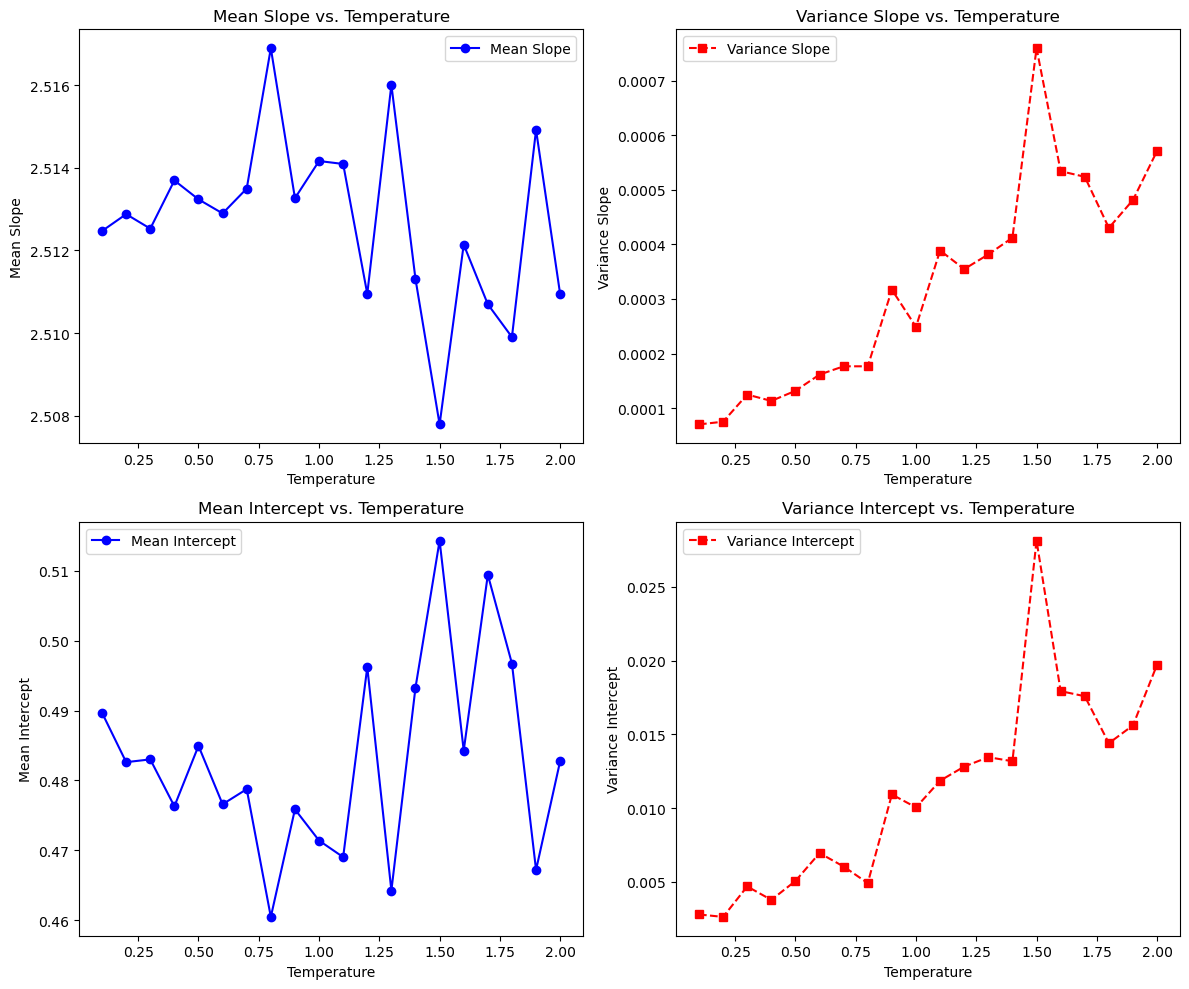

In [12]:
# Arrays to store results
slope_means = []
intercept_means = []
slope_variances = []
intercept_variances = []

# Define different temperatures to test
temperatures_array = np.linspace(0.1, 2.0, 20)

for temperature in temperatures_array:
    print(f"Fitting model with the temperature: {temperature}")
    with model:
        # Setup SVGD
        svgd = pm.SVGD(n_particles=100, jitter=0.1, temperature = temperature)
        # Run SVGD
        approx = svgd.fit(13000)
        # Sample from the approximate posterior
        trace = approx.sample(100)
        # Calculate and store means and variances
        slope_mean = np.mean(trace.posterior["slope"].values)
        intercept_mean = np.mean(trace.posterior["intercept"].values)
        slope_variance = np.var(trace.posterior["slope"].values)
        intercept_variance = np.var(trace.posterior["intercept"].values)

        slope_means.append(slope_mean)
        intercept_means.append(intercept_mean)
        slope_variances.append(slope_variance)
        intercept_variances.append(intercept_variance)

# Setting up the plot layout
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))  # 2x2 grid of subplots

# Plot Mean Slope
axes[0, 0].plot(temperatures_array, slope_means, marker='o', linestyle='-', color='blue', label='Mean Slope')
axes[0, 0].set_title('Mean Slope vs. Temperature')
axes[0, 0].set_xlabel('Temperature')
axes[0, 0].set_ylabel('Mean Slope')
axes[0, 0].legend()

# Plot Variance Slope
axes[0, 1].plot(temperatures_array, slope_variances, marker='s', linestyle='--', color='red', label='Variance Slope')
axes[0, 1].set_title('Variance Slope vs. Temperature')
axes[0, 1].set_xlabel('Temperature')
axes[0, 1].set_ylabel('Variance Slope')
axes[0, 1].legend()

# Plot Mean Intercept
axes[1, 0].plot(temperatures_array, intercept_means, marker='o', linestyle='-', color='blue', label='Mean Intercept')
axes[1, 0].set_title('Mean Intercept vs. Temperature')
axes[1, 0].set_xlabel('Temperature')
axes[1, 0].set_ylabel('Mean Intercept')
axes[1, 0].legend()

# Plot Variance Intercept
axes[1, 1].plot(temperatures_array, intercept_variances, marker='s', linestyle='--', color='red', label='Variance Intercept')
axes[1, 1].set_title('Variance Intercept vs. Temperature')
axes[1, 1].set_xlabel('Temperature')
axes[1, 1].set_ylabel('Variance Intercept')
axes[1, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

This experiment shows us on the left that the mean both of slope and intercept don't follow a specific trend when increasing the temperature. However, the means fluctuate more with an increased temperature and more exploration. This is different for the variance of slope and intercept. The variances are increasing with higher temperature. This is little surprising given the explanation of the temperature as the parameter responsible for exploration.

In [13]:
# Define the PyMC model
with pm.Model() as model:
    slope = pm.Normal('slope', mu=0, sigma=10)
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    y_est = intercept + slope * x
    likelihood = pm.Normal('y', mu=y_est, sigma=1, observed=y)

    # Run SVGD with different temperatures
    traces = {}
    temperatures = [0.1, 1, 5]  # Different temperatures for SVGD
    for temp in temperatures:
        svgd = pm.SVGD(n_particles=100, jitter=0.1, temperature=temp)
        approx = svgd.fit(10000)
        trace = approx.sample(1000)
        traces[f'temp_{temp}'] = trace.posterior

Output()

Output()

Output()

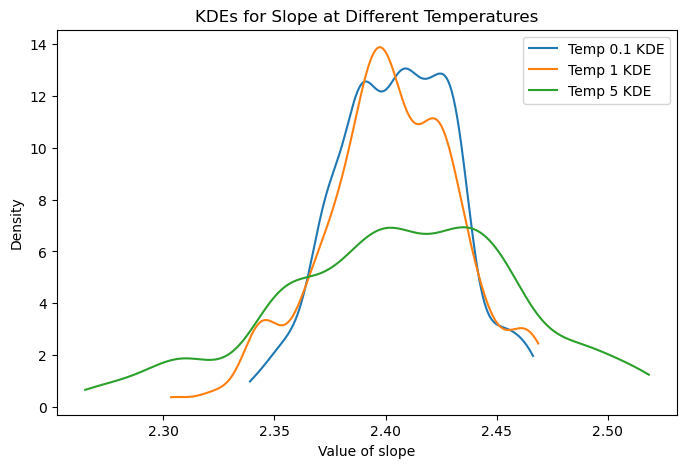

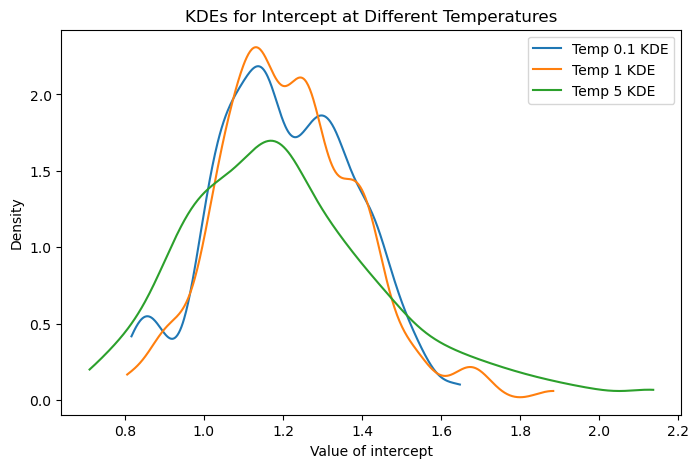

In [14]:
# Plotting the results
params = ['slope', 'intercept']
for param in params:
    plt.figure(figsize=(8, 5))
    plt.title(f'KDEs for {param.capitalize()} at Different Temperatures')
    for temp in temperatures:
        svgd_samples = traces[f'temp_{temp}'][param].values.flatten()
        kde_svgd = gaussian_kde(svgd_samples)
        x_range_svgd = np.linspace(min(svgd_samples), max(svgd_samples), 500)
        plt.plot(x_range_svgd, kde_svgd(x_range_svgd), label=f"Temp {temp} KDE")
    
    plt.xlabel(f'Value of {param}')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

[**PABLO COMMENT FOR TIM**][remove before deadline]: This part is super nice. I think also the teacher would like if we add the posterior distribution plots for different parameters. For instance:
- plot posterior distributions for nb of iterations: 1000, 10000 and 15000
- same but with nb of particles: 100, 500 and 1000
- same but with temperature (here, since the temperature is supposed to give us a broader estimation of the posterior it is particularly interesting)

## 2.2 Artificial Data - Langevin

In [15]:
rng = default_rng()
#Function to compute the gradient of the potential for artificial data
def grad_potential_artificial(params: np.ndarray,
                   sigma_params: float,
                   sigma_data: float,
                   X: np.ndarray,
                   Y: np.ndarray) -> np.ndarray:
    '''
    params : array containing intercept and slope of the artificial data
    sigma_params : variance associated to prior of params
    sigma_data : variance associated to normal likelihood
    X: array for covariable of size N
    Y: array for target of size N
    '''

    intercept_ = params[0]
    slope_ = params[1]
    grad = np.empty(2)

    grad[1] = -np.sum(X*(Y - slope_*X - intercept_)/(sigma_data)**2) + slope_/(sigma_params)**2

    grad[0] = -np.sum((Y - slope_*X - intercept_)/(sigma_data)**2) + intercept_/(sigma_params)**24


    return grad


def langevin_artificial(gamma, X, Y, sigma_data, params_star, sigma_params, seed, K=1000, print_freq=10000):
    np.random.seed(seed)
    params0 = np.random.normal(0, 1, 2)
    params = []
    error = []

    for i in range(K):

        xi = rng.multivariate_normal(np.zeros(2), np.eye(2))
        params_new = params0 - gamma * grad_potential_artificial(params0, sigma_params, sigma_data, X, Y) + np.sqrt(2*gamma) * xi
        params.append(params_new)
        error.append(np.linalg.norm(params_new - params_star))
        if i == 0 or i % print_freq == print_freq - 1:
            print('iteration {}: error = {}'.format(i + 1, np.linalg.norm(params_new - params_star)))
        params0 = params_new

    return params, error

j = 0
iteration 1: error = 2.3726373716540166
iteration 10000: error = 1.0986262436065612
iteration 20000: error = 0.8208873969275011
iteration 30000: error = 0.569767595935294
iteration 40000: error = 0.3499026900524183
iteration 50000: error = 0.012931416401613277
iteration 60000: error = 0.036524169139438296
iteration 70000: error = 0.042946878301431166
iteration 80000: error = 0.02892104660395183
iteration 90000: error = 0.3360545739100363
iteration 100000: error = 0.21540581821048127
iteration 110000: error = 0.3264197615801071
iteration 120000: error = 0.10980426934893094
iteration 130000: error = 0.16989084460059745
iteration 140000: error = 0.1003704571261119
iteration 150000: error = 0.10334997775701085
j = 0
iteration 1: error = 2.3192263734331595
iteration 10000: error = 0.12874729012313185
iteration 20000: error = 0.14432565750139237
iteration 30000: error = 0.09316627815735692
iteration 40000: error = 0.35535324172039634
iteration 50000: error = 0.0979672775896623
iteratio

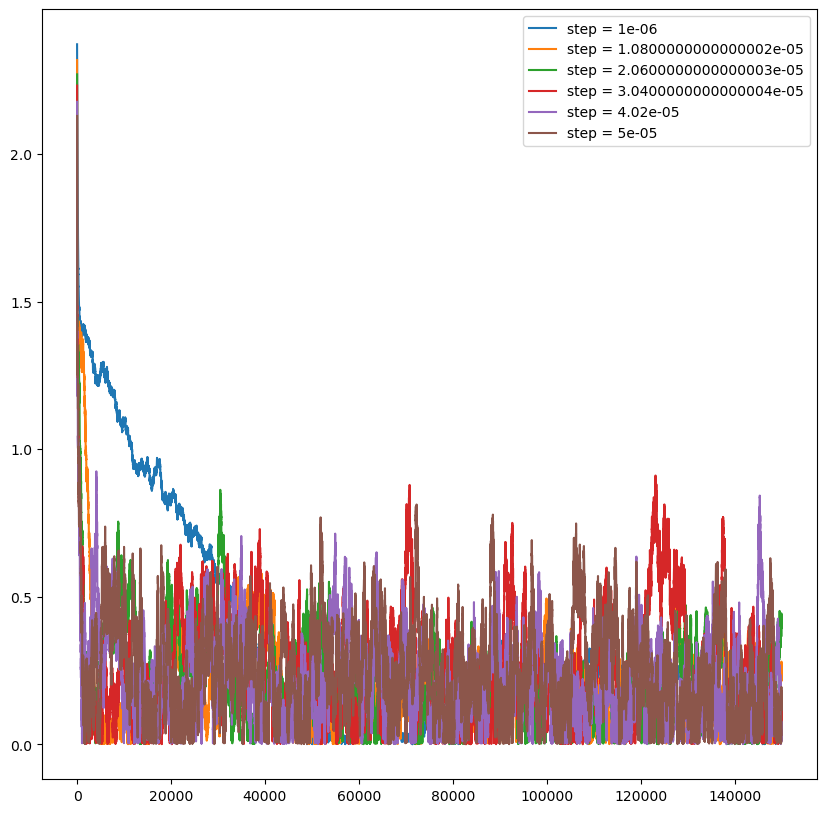

In [16]:
# we run the langevin for different step sizes and compare them
Params1 = []
Error1 = []

K = 150000
gamma = np.linspace(1e-6,5e-5, 6)
S = 1

sigma_data = 1.
sigma_params = 3.
params_star = np.array([true_intercept, true_slope])



plt.figure(figsize = (10,10))
for i in range(6):
  for j in range(S):
    print('j =', j)
    params1, error1 = langevin_artificial(gamma[i], x, y, sigma_data, params_star, sigma_params, j, K)
    Params1.append(params1)
    Error1.append(error1)
    plt.plot(np.arange(K), error1, label =f'step = {gamma[i]}')

plt.legend(loc="upper right")
plt.show()

We can see that the Langevin Gradient Descent has the same properties as the classic Gradient Descent when looking at the step size. Indeed, the lower the step size, the slower the algorithm will converge. When the step_size is too high (1e-3 for instance), the algorithm diverges (explodes). It seems also , that when the step size becomes too big, the algorithm does not converge to a lower error value, which seems logical because when the algorithm gets too close to the maximum likelihood estimator, a big step size (and taking into account that the there is noise) is going to drive the algorithm far from the highest denisity points.

We therefore use a step size of 1e-6, to be sure that the algorithm converges. We also use more iterations, and burn the first 30000 from the sample.

In [17]:
K = 200000
gamma = 1e-6
S = 1
Params1 = []

sigma_data = 1.
sigma_params = 3.
params_star = np.array([true_intercept, true_slope])

for j in range(S):
    print('j =', j)
    params1, error1 = langevin_artificial(gamma, x, y, sigma_data, params_star, sigma_params, j, K)
    Params1.append(params1)

params1 = np.mean(np.array(Params1), axis=0)

j = 0
iteration 1: error = 2.372798994723858
iteration 10000: error = 1.1389459425354618
iteration 20000: error = 0.8948741333321547
iteration 30000: error = 0.7567643953106237
iteration 40000: error = 0.676071066292428
iteration 50000: error = 0.5272710377489244
iteration 60000: error = 0.5496793038619092
iteration 70000: error = 0.23542479229260818
iteration 80000: error = 0.0831794710113929
iteration 90000: error = 0.08502068023037651
iteration 100000: error = 0.19940662091724137
iteration 110000: error = 0.10088804958061971
iteration 120000: error = 0.1209176159365536
iteration 130000: error = 0.024043113629516354
iteration 140000: error = 0.20639062765470795
iteration 150000: error = 0.23454495687594476
iteration 160000: error = 0.06025285525199127
iteration 170000: error = 0.14529291583686202
iteration 180000: error = 0.2059962338444575
iteration 190000: error = 0.3365168281317978
iteration 200000: error = 0.33498828853748


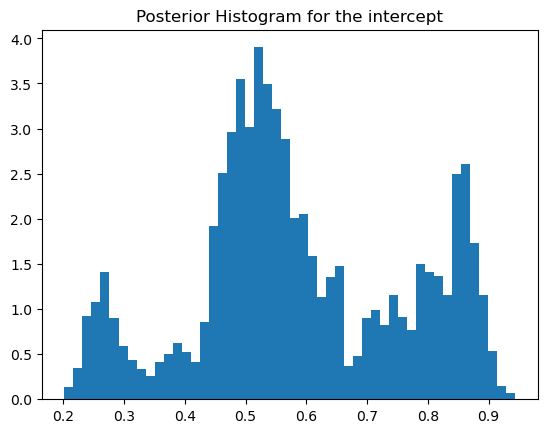

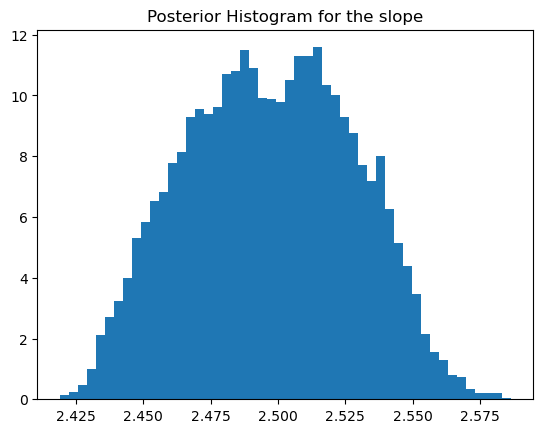

In [18]:
# We look at the posteriors for the langevin at step=1e-6
for i in range(2):
  if i==0: param = 'intercept'
  else: param = 'slope'
  plt.figure()
  plt.title(f"Posterior Histogram for the {param}")
  plt.hist(params1[int(K/2):K, i],density=True, bins=50, label="Langevin")

We can observe that the posteriors for both the intercept and the slope look like normal distributions approximately centered around their true value (0.65 for the intercept and 2.5 for the slope). This is consisitent with the fact that both the priors and the likelihood are normal distributions. We expect the posterior to be normal also. Nevertheless, the results shown above are for a step of 1e-6 and 200000. When running the algorithm with less iterations, the algorithm has trouble finding a consistent posterior for the intercept.

#### Sanity Checks and Summary

In [19]:
# we do a Bayesian Model Average to do a point prediction of the target
param_bma = params1.mean(axis = 0) # since the model is linear, we can directly take the mean of the sample
y_pred = param_bma[0] + x*param_bma[1]

rmse = np.sqrt(np.mean((y - y_pred) ** 2))
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 0.9265269747683271


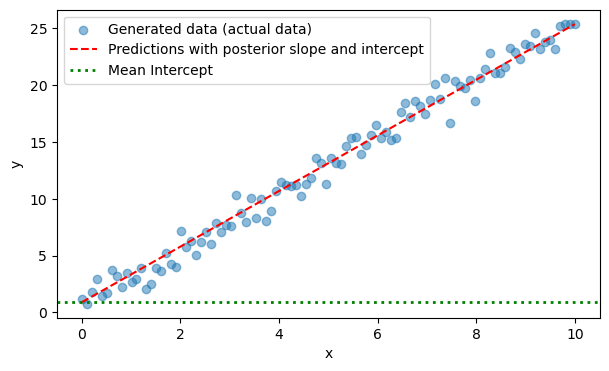

In [20]:
plt.figure(figsize=(7, 4))
plt.scatter(x, y, alpha=0.5, label='Generated data (actual data)')
plt.plot(x, y_pred, 'r--', label='Predictions with posterior slope and intercept')
plt.xlabel('x')
plt.ylabel('y')
plt.axhline(y=np.mean(param_bma[0]), color='g', linestyle=':', linewidth=2, label='Mean Intercept')
plt.legend()
plt.show()

In [21]:
# Extracting data for 'slope' and 'intercept'
slope_samples = params1[:,1]
intercept_samples = params1[:,0]

# Calculate means and variances
slope_mean = np.mean(slope_samples)
intercept_mean = np.mean(intercept_samples)
slope_variance = np.var(slope_samples)
intercept_variance = np.var(intercept_samples)

print("Posterior Mean of Slope:", slope_mean)
print("Posterior Variance of Slope:", slope_variance)
print("Posterior Mean of Intercept:", intercept_mean)
print("Posterior Variance of Intercept:", intercept_variance)

# Calculate the standard deviation from the variance
slope_std_dev = np.sqrt(slope_variance)
intercept_std_dev = np.sqrt(intercept_variance)

print("Standard Deviation of Slope:", slope_std_dev)
print("Standard Deviation of Intercept:", intercept_std_dev)

Posterior Mean of Slope: 2.4488680573798645
Posterior Variance of Slope: 0.00825915913902661
Posterior Mean of Intercept: 0.8896227651850733
Posterior Variance of Intercept: 0.19931939695439163
Standard Deviation of Slope: 0.09087991603773966
Standard Deviation of Intercept: 0.4464520096879301


## 2.3 Comparison of SVGD and Langevin for Artificial Data

In [22]:
# Initial data setup
data = {
    'Measure': [
        'Slope Mean', 'Slope Variance', 'Slope Standard Deviation',
        'Intercept Mean', 'Intercept Variance', 'Intercept Standard Deviation'
    ],
    'SVGD': [
        slope_mean_svgd, slope_variance_svgd, slope_std_dev_svgd,
        intercept_mean_svgd, intercept_variance_svgd, intercept_std_dev_svgd
    ],
    'Langevin': [
        slope_mean, slope_variance, slope_std_dev,
        intercept_mean, intercept_variance, intercept_std_dev
    ]
}

# Creating DataFrame
comparison_df = pd.DataFrame(data)

# Calculate the deltas
comparison_df['Delta'] = comparison_df['SVGD'] - comparison_df['Langevin']

# Set 'Measure' as the index for the DataFrame
comparison_df.set_index('Measure', inplace=True)

# Display the DataFrame
comparison_df

,SVGD,Langevin,Delta
Measure,,,
Slope Mean,2.513145,2.448868,0.064277
Slope Variance,0.000310,0.008259,-0.007949
Slope Standard Deviation,0.017603,0.090880,-0.073277
Intercept Mean,0.477912,0.889623,-0.411711
Intercept Variance,0.009806,0.199319,-0.189513
Intercept Standard Deviation,0.099027,0.446452,-0.347425


Here, we have taken the mean, variance and standard deviation for slope and intercept of 

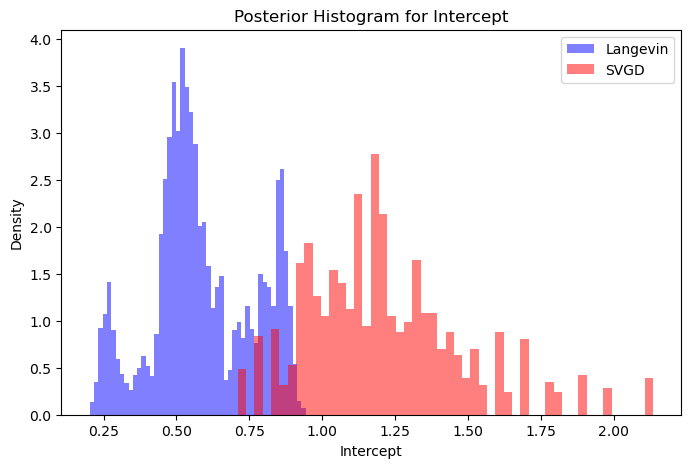

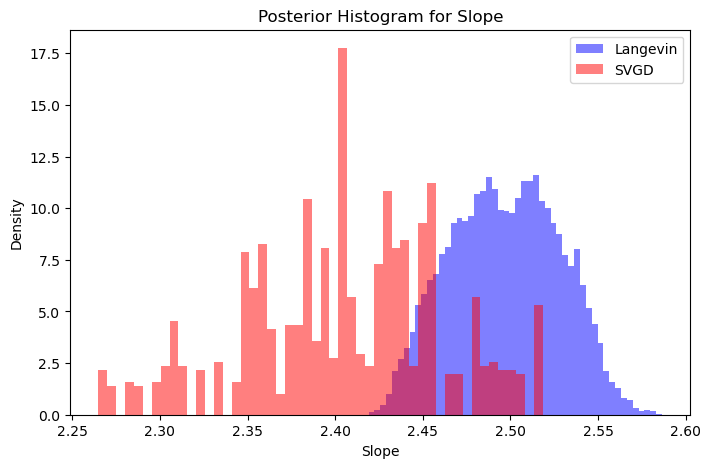

In [23]:
# Histogram settings
bins = 50  # Number of bins for histogram
alpha = 0.5  # Transparency for histogram

# Plot settings
params = ['intercept', 'slope']
param_names = {'intercept': 'Intercept', 'slope': 'Slope'}  # for titles and labels

# Start plotting
for i, param in enumerate(params):
    plt.figure(figsize=(8, 5))
    plt.title(f"Posterior Histogram for {param_names[param]}")

    # Langevin Histogram
    plt.hist(params1[int(K/2):K, i], density=True, bins=bins, alpha=alpha, label="Langevin", color='blue')

    # SVGD Histogram
    svgd_samples = trace.posterior[param].values.flatten()  # Make sure 'slope' and 'intercept' are correctly referenced
    plt.hist(svgd_samples, density=True, bins=bins, alpha=alpha, label="SVGD", color='red')

    plt.xlabel(param_names[param])
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# 3. Simulated Data for Bayesian Logistic Regression

In [24]:
rng = default_rng()

# Set random seed for reproducibility
#np.random.seed(0)

# simulation of data points

d = 10 #number of variables
N = 1000 #number of observations

sigma_theta = 2
theta_star =  np.sqrt(sigma_theta) * np.random.randn(d)


# Generate data
X = np.random.randn(d, N)
logit = np.exp(np.dot(theta_star, X)) / (1 + np.exp(np.dot(theta_star, X)))
Y = np.random.binomial(1, logit)

# Define the proportion of data to be used for testing
test_size = 0.2

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X.T, Y, test_size=test_size, random_state=42)

# Transpose X_train and X_test back to their original shapes
X_train = X_train.T
X_test = X_test.T

X, Y = X_train, Y_train

## 3.1 Langevin Algorithm


In [25]:
# Function to compute the gradient of the potential

def grad_potential(theta: np.ndarray,
                   sigma_theta: int,
                   X: np.ndarray,
                   Y: np.ndarray) -> np.ndarray:
    '''
    theta: d by 1 vector: parameter of the Bayesian logistic regression model
    X: d by N matrix: each column is X_n
    Y: N by 1 vector: each entry is Y_n
    '''
    return - np.einsum('i,ji->j', Y - scipy.special.expit(np.dot(theta, X)), X) + theta/sigma_theta

# Init
np.zeros(100)

#ULA

def langevin(gamma, lam, X, Y, theta_star, sigma_theta, seed, d=100, K=1000, print_freq=10000):
    np.random.seed(seed)
    theta0 = np.random.normal(0, 1, d)
    theta = []
    error = []

    for i in range(K):
        xi = rng.multivariate_normal(np.zeros(d), np.eye(d))
        theta_new = theta0 - gamma * grad_potential(theta0, sigma_theta, X, Y) + np.sqrt(2*gamma) * xi
        theta.append(theta_new)
        error.append(np.linalg.norm(theta_new - theta_star))
        if i == 0 or i % print_freq == print_freq - 1:
            print('iteration {}: error = {}'.format(i + 1, np.linalg.norm(theta_new - theta_star)))
        theta0 = theta_new

    return theta, error


j = 0
iteration 1: error = 5.362822831840247
iteration 10000: error = 0.5388659655979899
iteration 20000: error = 0.6324215399342854
iteration 30000: error = 0.8497410037287777
iteration 40000: error = 0.525960254261132


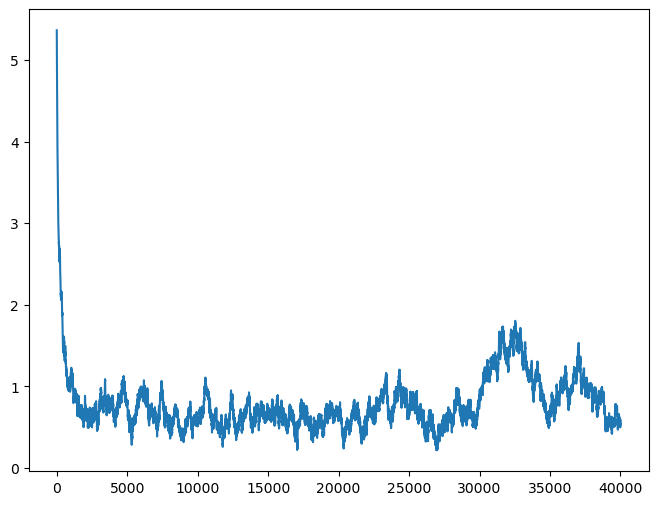

In [26]:
# ULA Main Loop

S = 1
Theta1 = []
Error1 = []

K = 40000
gamma = 1e-4

for j in range(S):
    print('j =', j)
    theta1, error1 = langevin(gamma, 1e-2, X, Y, theta_star, sigma_theta, j, d, K)
    Theta1.append(theta1)
    Error1.append(error1)

theta1 = np.mean(np.array(Theta1), axis=0)
error1 = np.array([np.linalg.norm(theta1[i] - theta_star) for i in range(K)])

plt.figure(0, figsize=(8,6))
plt.plot(np.arange(K), error1)

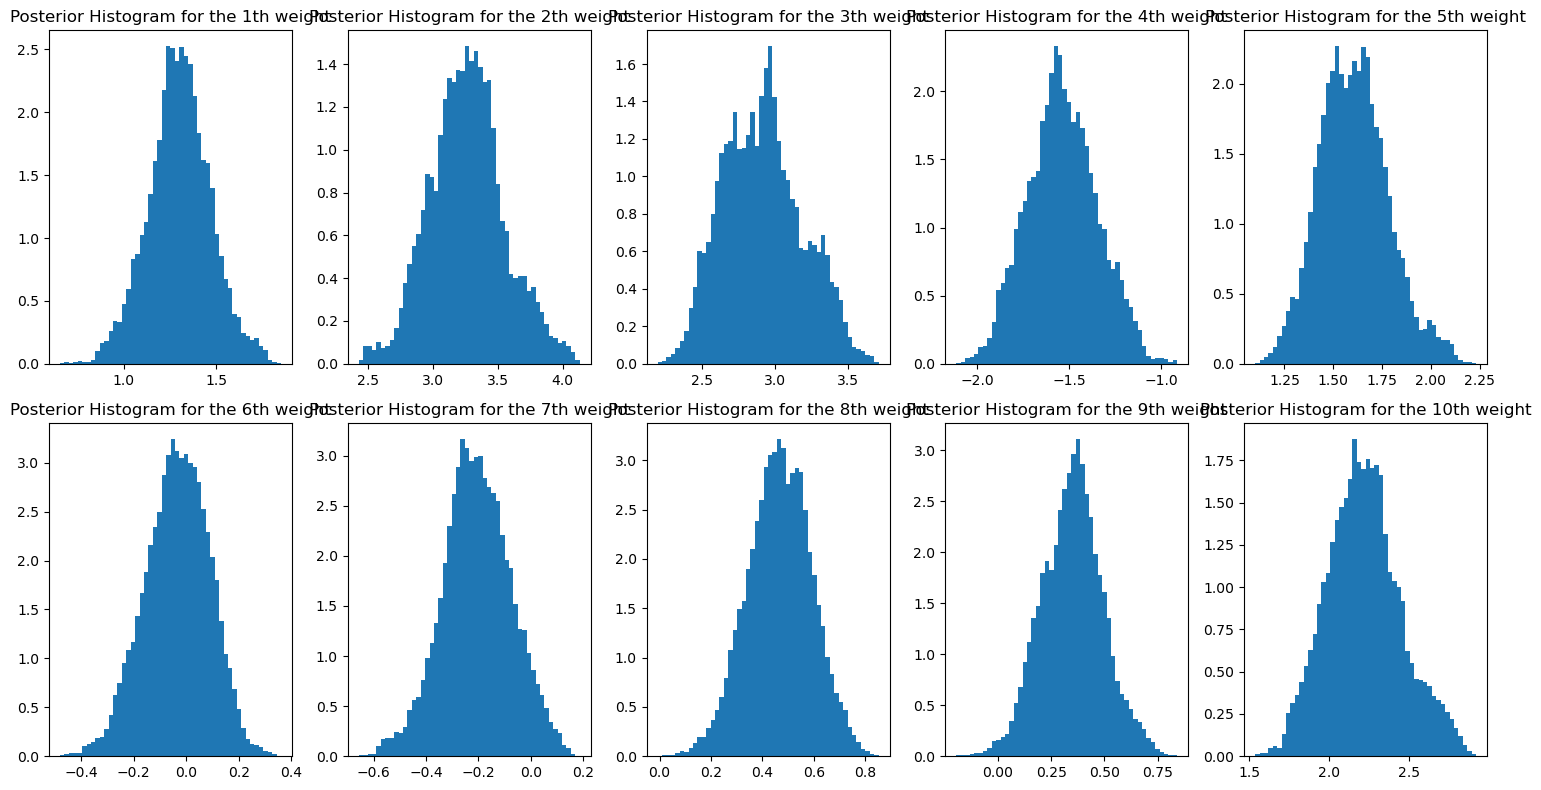

In [27]:
# Create a figure and subplots
fig, axs = plt.subplots(2, 5, figsize=(15, 8))

# Flatten the axs array to make it easier to work with
axs = axs.flatten()

# Plot each curve in its respective subplot
for i in range(d):
    ax = axs[i]
    ax.hist(theta1[int(K/10):K, i],density=True, bins=50, label="Langevin")
    ax.set_title(f"Posterior Histogram for the {i+1}th weight")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [28]:
def predict_posterior_samples(theta_samples, X_test):
    """
    Predict labels for test data using samples from the posterior distribution.

    Parameters:
        theta_samples (ndarray): Samples from the posterior distribution of parameters.
        X_test (ndarray): Test data features.

    Returns:
        ndarray: Predicted labels for test data.
    """
    num_samples = len(theta_samples)
    num_test_points = X_test.shape[1]
    predictions = np.zeros(num_test_points)
    logit = np.zeros(num_test_points) #new

    for theta in theta_samples:
        #logit = np.exp(np.dot(theta, X_test)) / (1 + np.exp(np.dot(theta, X_test)))
        #sample_predictions = (logit > 0.5).astype(int)
        #predictions += sample_predictions
        logit += np.exp(np.dot(theta, X_test)) / (1 + np.exp(np.dot(theta, X_test))) #new

    #average_predictions = predictions / num_samples
    average_predictions = (logit > 0.5*num_samples).astype(int) #new


    return np.round(average_predictions)


# Assuming you have your test data in X_test and true labels in Y_test
# Predict labels using posterior samples
predicted_labels = predict_posterior_samples(theta1, X_test)

# Compute accuracy
accuracy = np.mean(predicted_labels == Y_test)
print("Accuracy:", accuracy)

Accuracy: 0.915


## 3.2 SVGD

In [29]:
# Step 1: Define the PyMC Model
# Here we define a Bayesian model with priors for slope and intercept, and a likelihood for observed data
with pm.Model() as simModel:
    # Priors for the unknown model parameters
    weights = pm.MvNormal('Weights', mu=0, cov = np.eye(X.shape[0]), shape=(X.shape[0],))

    # Calculate probabilities using the logistic function
    logits = pm.math.dot(weights, X)
    probability = pm.Deterministic('probability', pm.math.sigmoid(logits))

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=probability, observed=Y)

    # Step 2: Set up SVGD
    # We use SVGD for Bayesian inference to approximate the posterior distribution of slope and intercept
    svgdSim = pm.SVGD(n_particles=200, jitter=0.1, model=simModel)

    # Step 3: Run SVGD
    # We perform the inference over 10,000 iterations to adjust particles to fit the target distribution
    approxSim = svgdSim.fit(15000)

Output()

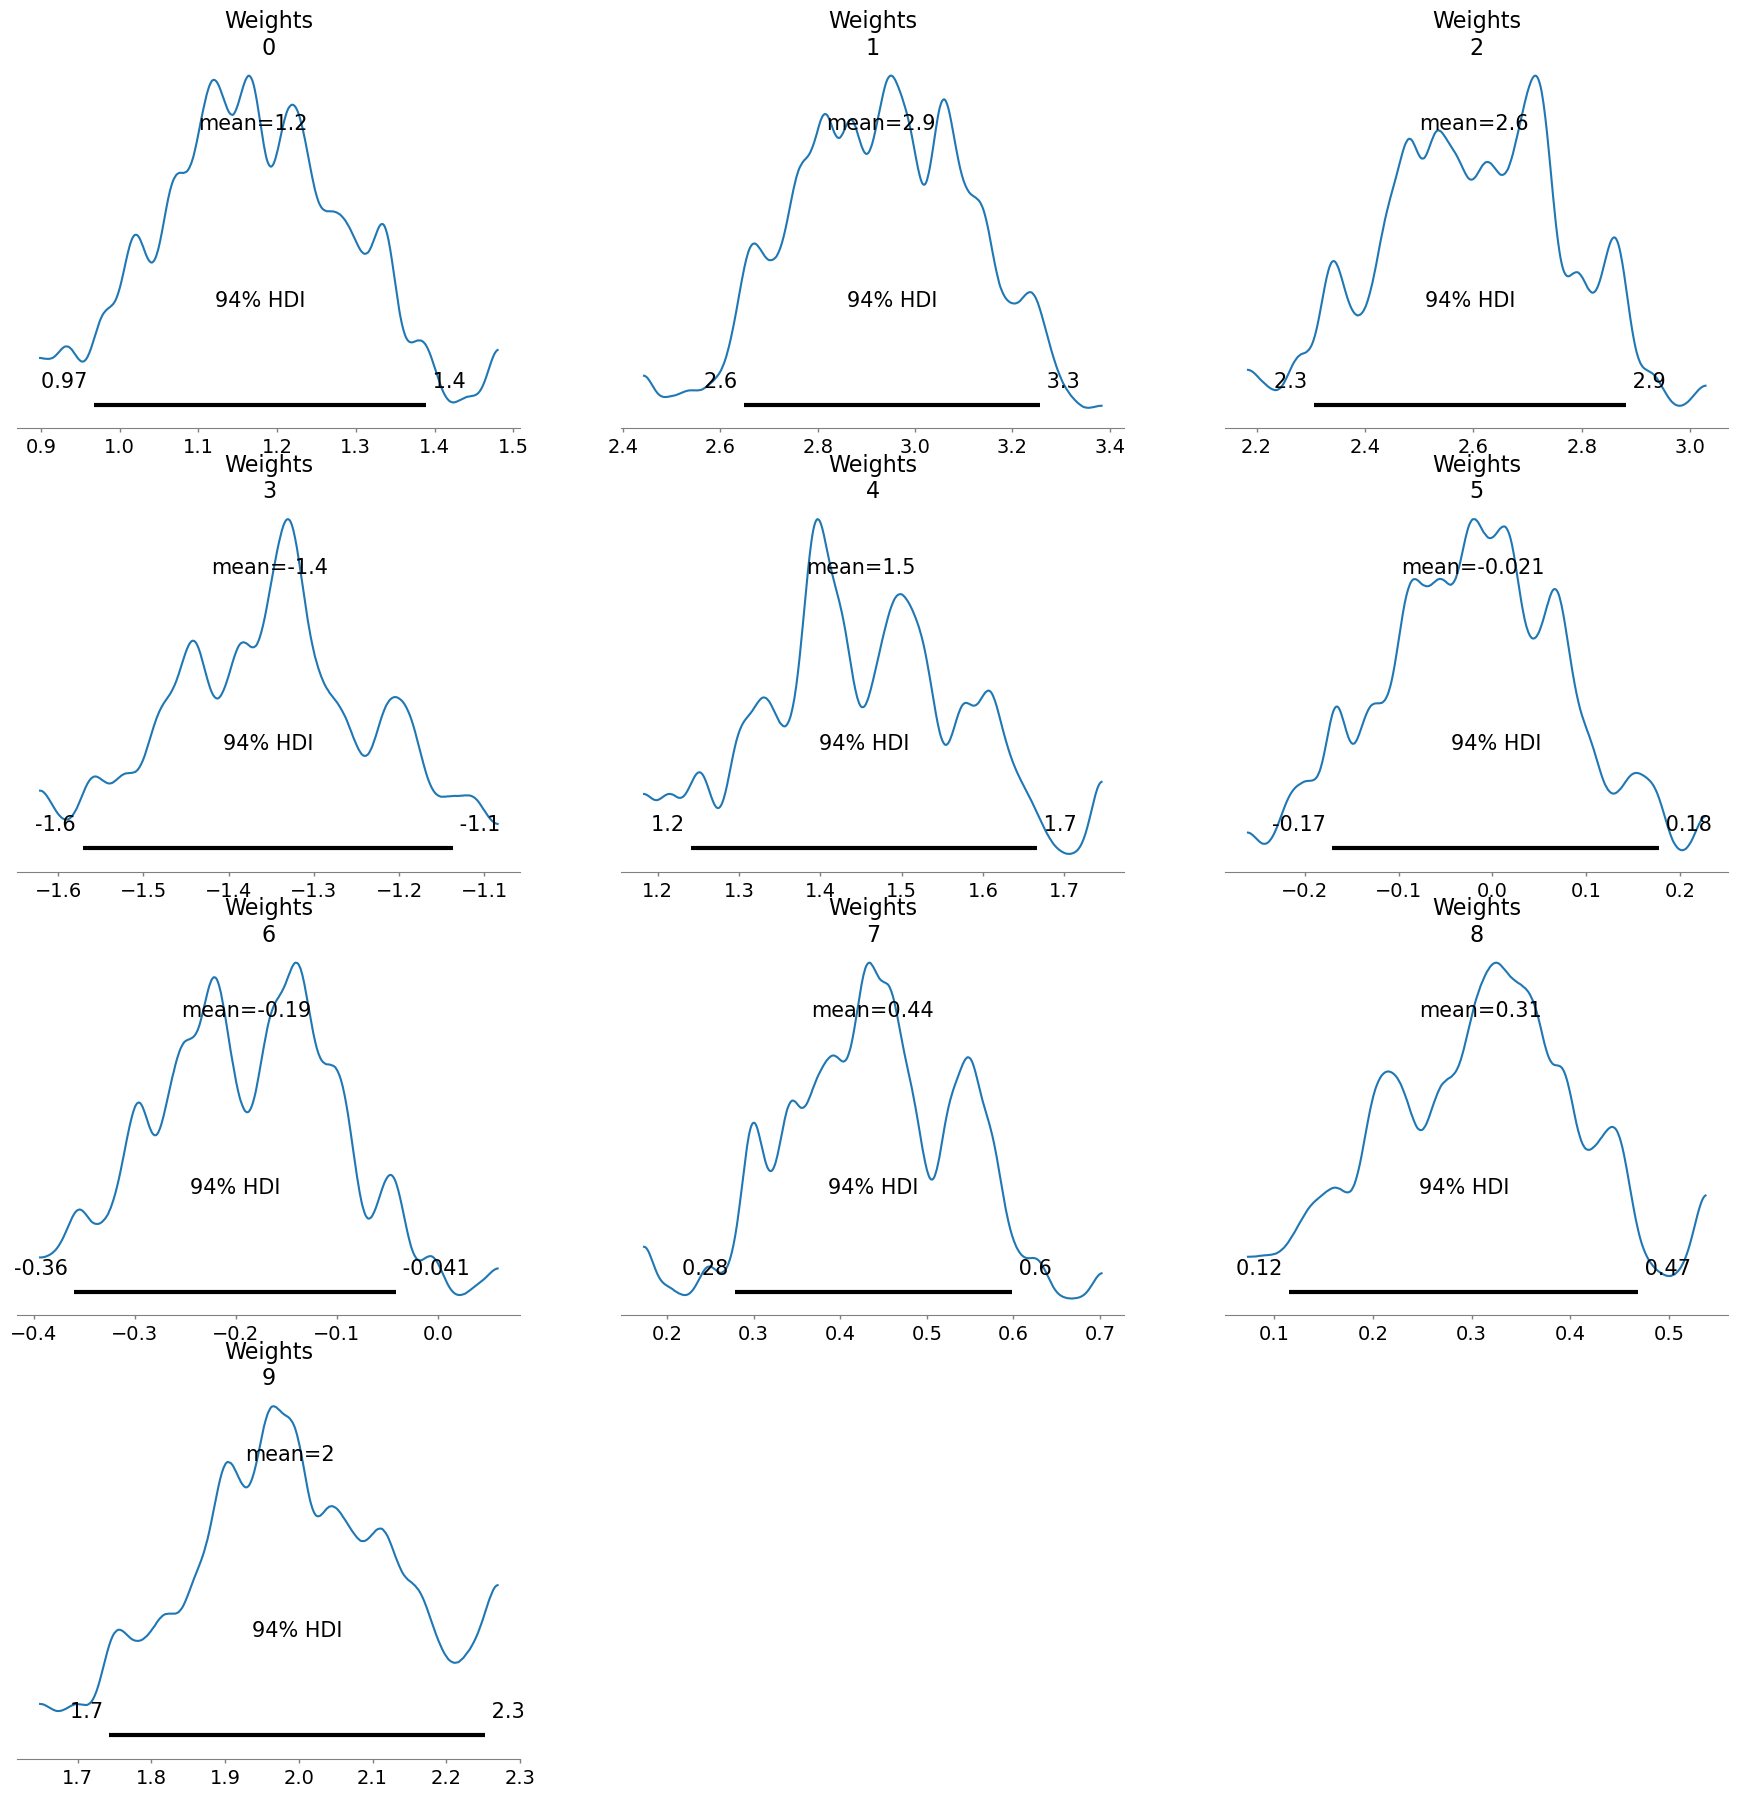

In [30]:
# Step 4: Sample from the Approximate Posterior
# samples from the distributions of slope and intercept
traceSim = approxSim.sample(1000)

# Step 5: Visualize the Results
pm.plot_posterior(traceSim, var_names=['Weights'])
plt.show()

# 4. Application to real data: the Wisconsin Breast Cancer (Diagnostic) Dataset

## 4.1 Introduction to the dataset

We decided on the utilization of the Wisconsin Breast Cancer (Diagnostic) Dataset. The advantage is that it is directly available via sklearn. Moreover, it does not contain any missing values. The disadvantage is maybe that with 30 there are a lot of features. However, this shouldn't be a real problem.

Additional information on the dataset can be found under this link: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

Here some basic descriptives of the dataset:

**Features:** 30 (real-valued inputs)

**Instances:** 569

**Problem:** Predict whether the cancer is benign or malignant based on cell nucleus characteristics.

**Benefits:** Offers a binary classification problem with more features than the Pima Indians dataset, allowing for a deeper exploration of feature relationships using logistic regression.

In the following cell, the dataset is simply loaded and the head (and below the info) is displayed for a quick overview:

In [31]:
# Load the dataset
data = load_breast_cancer()

# Create a DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)

# Add the target variable to the DataFrame
df['target'] = data.target

# Display the first few rows of the DataFrame, only 3 as the output would be a bit long otherwise
print(df.head(3))

# Show the shape of the DataFrame to verify
print("Data shape:", df.shape)

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38           122.8     1001.0          0.11840   
1        20.57         17.77           132.9     1326.0          0.08474   
2        19.69         21.25           130.0     1203.0          0.10960   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07871  ...          17.33            184.6      2019.0   
1                 0.05667  ...          23.41            158.8      1956.0   
2                 0.05999  ...          25.53            152.5      1709.0   

   worst smoothness  worst compactness  worst concavity  worst concave points  \


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

We did not normalize the data in the beginning but encountered an error when trying to fit the model down below. Normalizing all 30 features (so that they are between 0 and 1 helped) to overcome this:

## 4.2 Short Preprocessing (Normalization)

In [33]:
# normalizing the features using the MinMaxScaler() from sklearn
scaler = MinMaxScaler()
feature_columns = df.columns[df.columns != 'target']
X = df[feature_columns].values
X_scaled = scaler.fit_transform(X)
df[feature_columns] = X_scaled
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864,0
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878,0
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433,0
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711,0
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595,0


## 4.3 Real Data - SVGD

Now, we take the code from above (SVGD and linear data) and adapt it to the real data. That includes that we don't have only one slope any more but 30 weights for 30 features instead. The target variable is Bernoulli distributed.

In [34]:
X = df.drop('target', axis=1).values  # Features
y = df['target'].values  # Target variable

In [35]:
# Step 1: Define the PyMC Model
# Here we define a Bayesian model with priors for slope and intercept, and a likelihood for observed data
with pm.Model() as cancerModel:
    # Priors for the unknown model parameters
    weights = pm.MvNormal('Weights', mu=0, cov = np.eye(30), shape=(X.shape[1],))

    # Calculate probabilities using the logistic function
    logits = pm.math.dot(X, weights)
    probability = pm.Deterministic('probability', pm.math.sigmoid(logits))

    # Likelihood (sampling distribution) of observations
    y_obs = pm.Bernoulli('y_obs', p=probability, observed=y)

    # Step 2: Set up SVGD
    # We use SVGD for Bayesian inference to approximate the posterior distribution of slope and intercept
    svgdCancer = pm.SVGD(n_particles=569, jitter=0.1, model=cancerModel)

    # Step 3: Run SVGD
    # We perform the inference over 10,000 iterations to adjust particles to fit the target distribution
    approxCancer = svgdCancer.fit(20000)

Output()

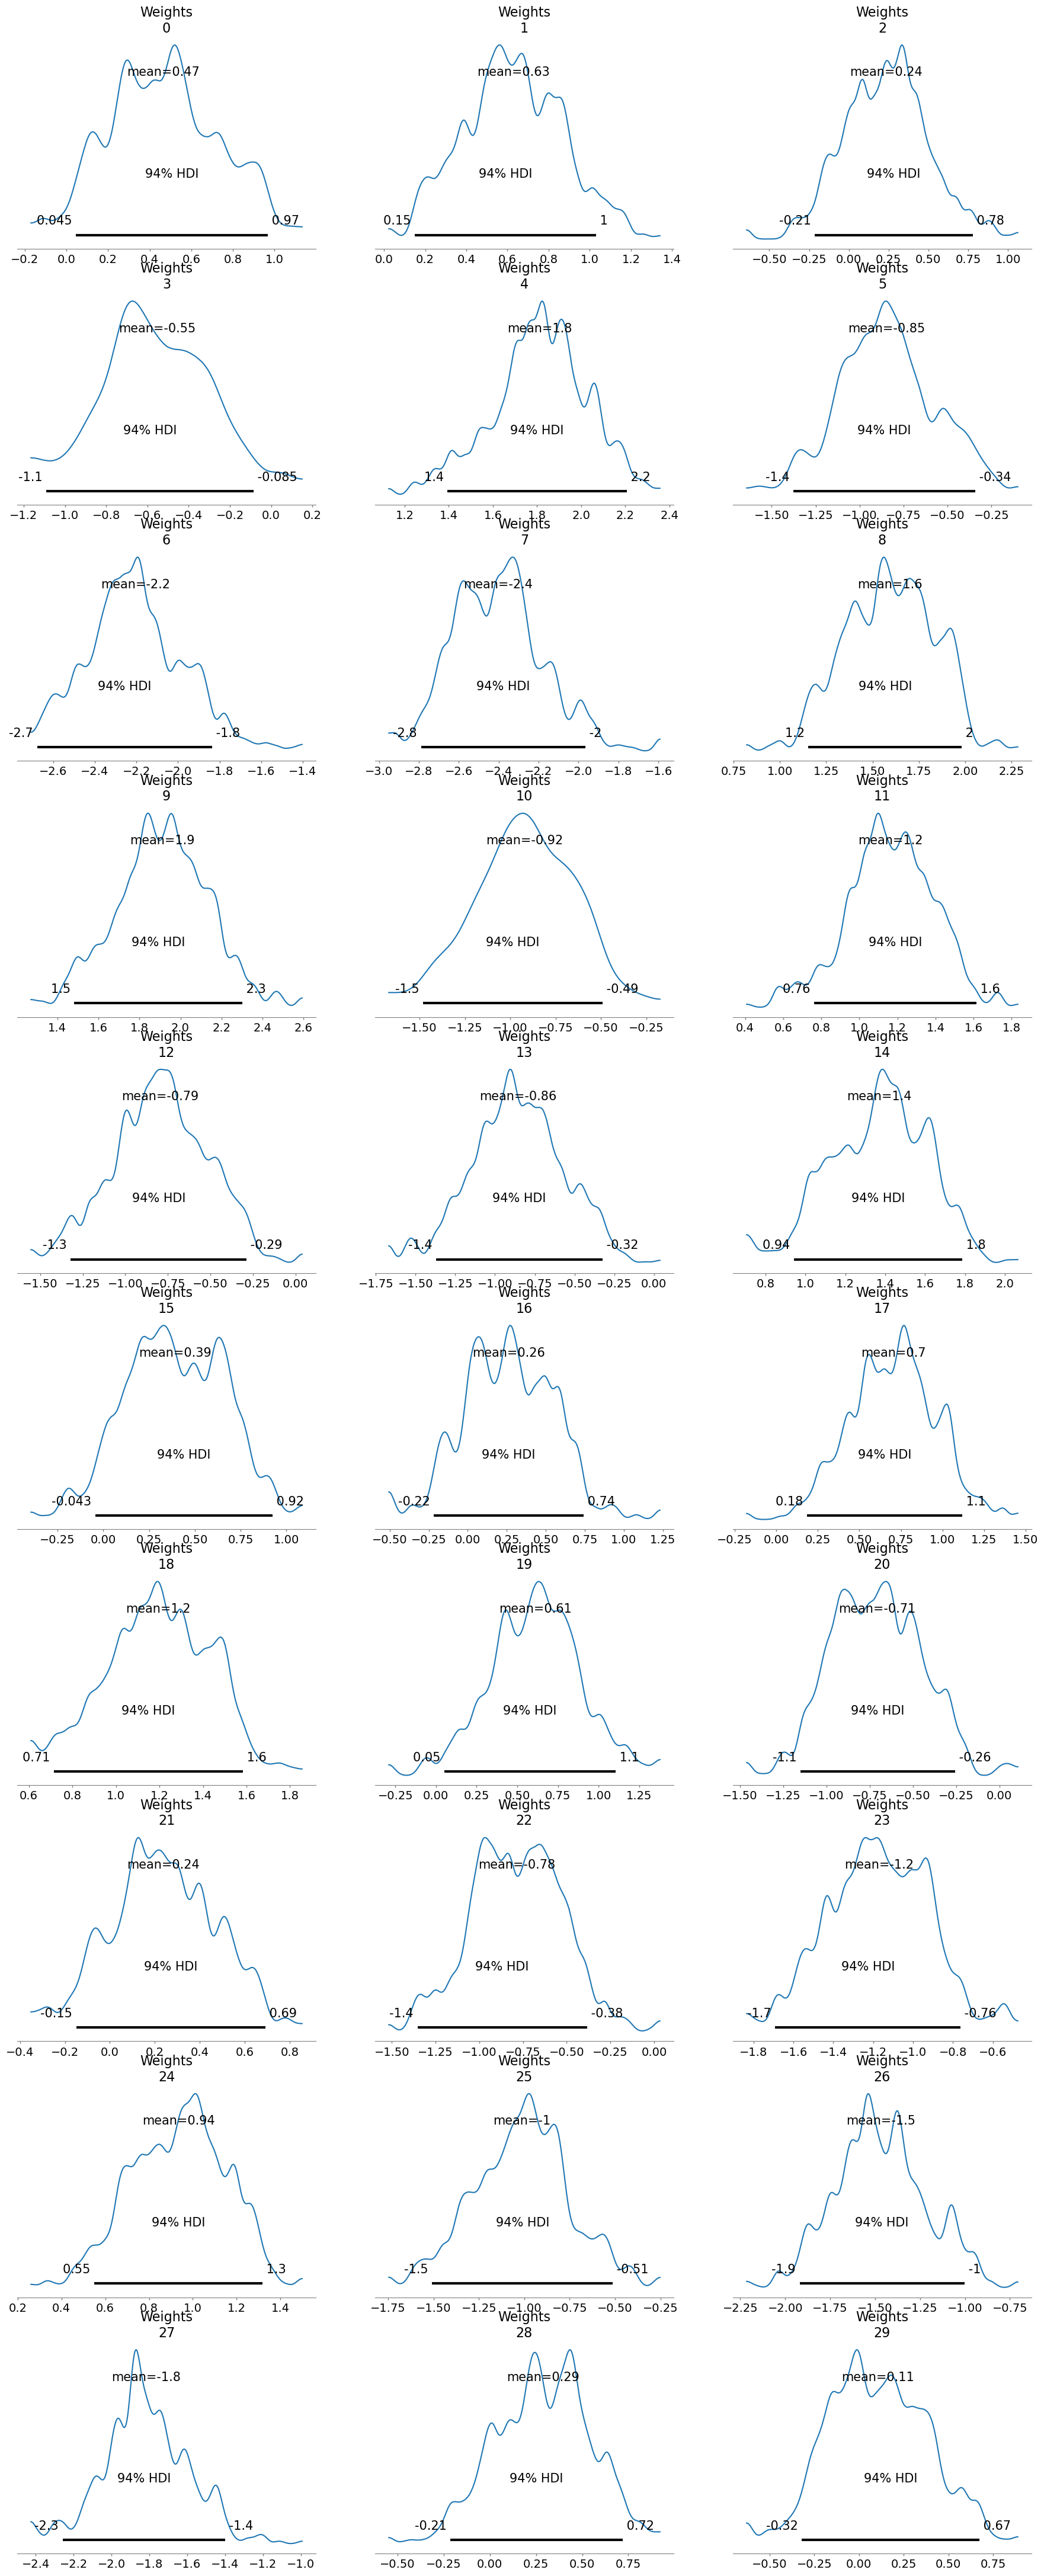

In [37]:
# Step 4: Sample from the Approximate Posterior
# samples from the distributions of slope and intercept
traceCancer = approxCancer.sample(1000)

# Step 5: Visualize the Results
pm.plot_posterior(traceCancer, var_names=['Weights'])
plt.show()

Initially, the distributions did not look that much like they are normally distributed. After that, we increased the number of particles in step two from 100 to 569 and the iterations from 10,000 to 20,000. That increased the time necessary for the fitting by a lot. However, it also lead to that the distributions are more looking like they are normally distributed and it decreased the delta between the observed and the predicted mean (see below).

### Analysis and Experiments of the SVGD with real data

At this point in time, the model from above should work and we can run some experiments that help to understand the results better.
First, we simply create a summary table showing for example mean and standard devitation for the different weights.


In [38]:
pm.summary(traceCancer, round_to=2)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Weights[0],0.47,0.26,0.05,0.97,0.01,0.01,889.67,922.25,NaN
Weights[1],0.63,0.24,0.15,1.03,0.01,0.01,965.78,971.68,NaN
Weights[2],0.24,0.27,-0.21,0.78,0.01,0.01,1079.41,814.07,NaN
Weights[3],-0.55,0.26,-1.09,-0.08,0.01,0.01,881.30,1025.75,NaN
Weights[4],1.81,0.22,1.39,2.21,0.01,0.00,1054.32,1029.88,NaN
...,...,...,...,...,...,...,...,...,...
probability[564],0.03,0.01,0.02,0.04,0.00,0.00,955.35,1060.13,NaN
probability[565],0.17,0.02,0.14,0.20,0.00,0.00,853.59,981.02,NaN
probability[566],0.28,0.02,0.24,0.32,0.00,0.00,919.87,868.28,NaN
probability[567],0.02,0.01,0.01,0.03,0.00,0.00,1084.31,893.72,NaN


PyMC also offers an option to create a graph of the model that has been learned. Have a look on the following link for more information:
https://www.pymc.io/projects/docs/en/latest/api/model/generated/pymc.model_graph.model_to_graphviz.html#pymc.model_graph.model_to_graphviz

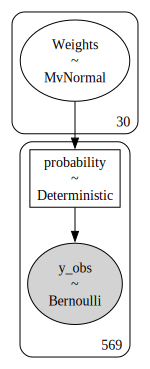

In [39]:
model_to_graphviz(cancerModel)

#### Predictive Checks

We now generate posterior predictive checks to see how well the model predicts new data. We're sampling from the posterior predictive distribution and compare these predictions to actual outcomes from the dataset.

Information can for example be found under the following link: https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html

After conducting the Bayesian inference and obtaining the posterior distribution of the parameters, we can generate new data sets from these parameters:

In [40]:
with cancerModel:
    # Sample from the posterior predictive distribution
    posterior_predictive = pm.sample_posterior_predictive(traceCancer, var_names=['y_obs'])

Sampling: [y_obs]


Output()

In [41]:
print(posterior_predictive.keys())

KeysView(Inference data with groups:
	> posterior_predictive
	> observed_data)


<Axes: xlabel='target', ylabel='Count'>

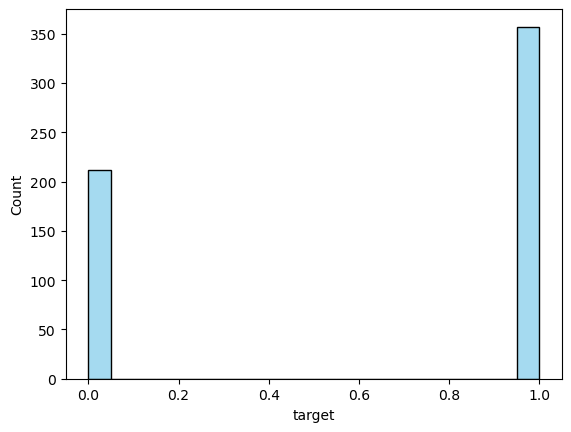

In [42]:
# Plot observed data
sns.histplot(data=df['target'], color="skyblue", label="Observed Data", kde=False, bins = 20)

<xarray.DataArray 'y_obs' (chain: 1, draw: 1000, y_obs_dim_2: 569)> Size: 5MB
array([[[0, 0, 0, ..., 1, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        ...,
        [0, 1, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 1, 0, ..., 0, 0, 1]]])
Coordinates:
  * chain        (chain) int64 8B 0
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * y_obs_dim_2  (y_obs_dim_2) int64 5kB 0 1 2 3 4 5 ... 563 564 565 566 567 568


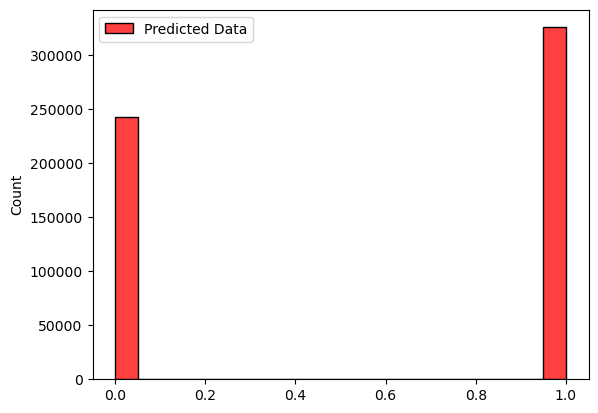

In [43]:
# Plot predicted data
posterior_predictive = posterior_predictive.posterior_predictive
predicted_data = posterior_predictive['y_obs']

# Check what's inside predicted_data
print(predicted_data)

# data had a 3D format with 1 markov chain, while sns.histplot() required 2D
flattened_data = predicted_data.values.flatten()

sns.histplot(flattened_data, color="red", label="Predicted Data", kde=False, bins = 20)

plt.legend()
plt.show()

At this point we have plotted both the predicted and the actual observed data in separate diagrams. For better comparison, we plot both of them in one diagram using the following cell.

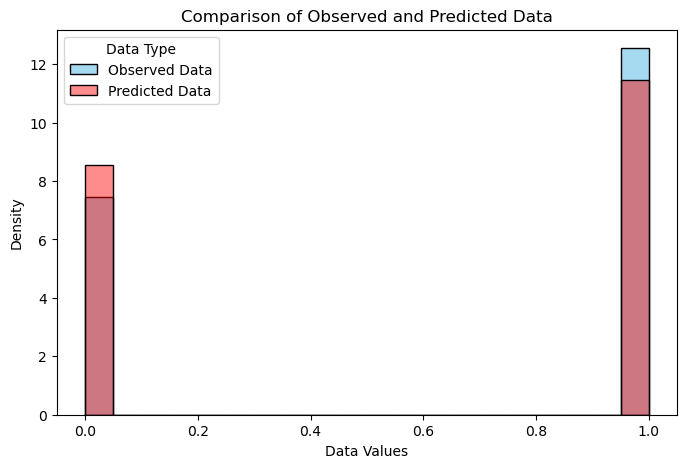

In [44]:
# Assuming df['target'] is your observed data
observed_data = df['target']

# Assume you already have your flattened_data from the posterior predictive
# Make sure to flatten your predicted data as you have done
flattened_data = predicted_data.values.flatten()

# Plot setup
plt.figure(figsize=(8, 5))

# Plotting observed data
sns.histplot(observed_data, color="skyblue", label="Observed Data", kde=False, stat="density", bins = 20)

# Plotting predicted data
sns.histplot(flattened_data, color="red", label="Predicted Data", kde=False, stat="density", alpha=0.45, bins = 20)

# Adding legend and titles
plt.legend(title="Data Type")
plt.title("Comparison of Observed and Predicted Data")
plt.xlabel("Data Values")
plt.ylabel("Density")
plt.show()

The observed and predicted mean is very similar, showing once more that the sampled data looks quite similar to the actual data from the dataset.

In [45]:
print("Observed Mean:", observed_data.mean())
print("Predicted Mean:", predicted_data.mean().item())

Observed Mean: 0.6274165202108963
Predicted Mean: 0.5728383128295255


## 4.4 Real Data - Langevin

In [46]:
# We transpose y and X so that we may use it on the Langevin functions
X = X.T #this should only be run once

j = 0
iteration 1: error = 6.366453447689155
iteration 10000: error = 10.481782628348293
iteration 20000: error = 9.49319392781551
iteration 30000: error = 10.03910665425541
iteration 40000: error = 10.997882395454445


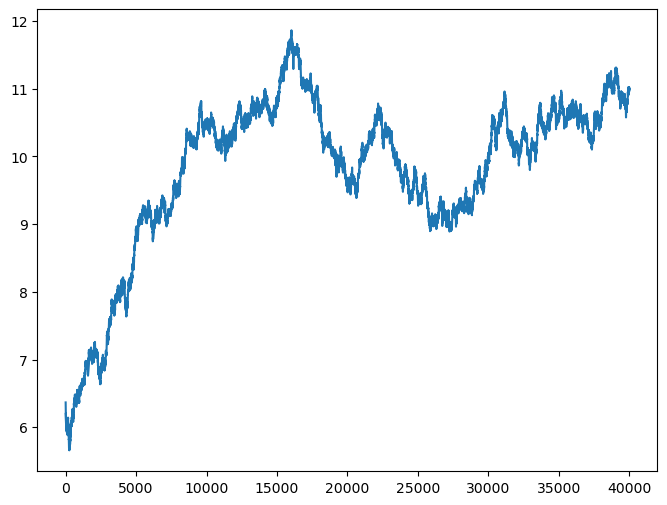

In [47]:
S = 1
Theta1 = []
Error1 = []

K = 40000
gamma = 1e-4
d = 30
theta_star = np.zeros(d)
sigma_theta = 1

for j in range(S):
    print('j =', j)
    theta1, error1 = langevin(gamma, 1e-2, X, y, theta_star, sigma_theta, j, d, K)
    Theta1.append(theta1)
    Error1.append(error1)

theta1 = np.mean(np.array(Theta1), axis=0)
error1 = np.array([np.linalg.norm(theta1[i] - theta_star) for i in range(K)])

plt.figure(0, figsize=(8,6))
plt.plot(np.arange(K), error1)

In [48]:
theta1.mean(axis = 0)[0]

1.7363592147821567

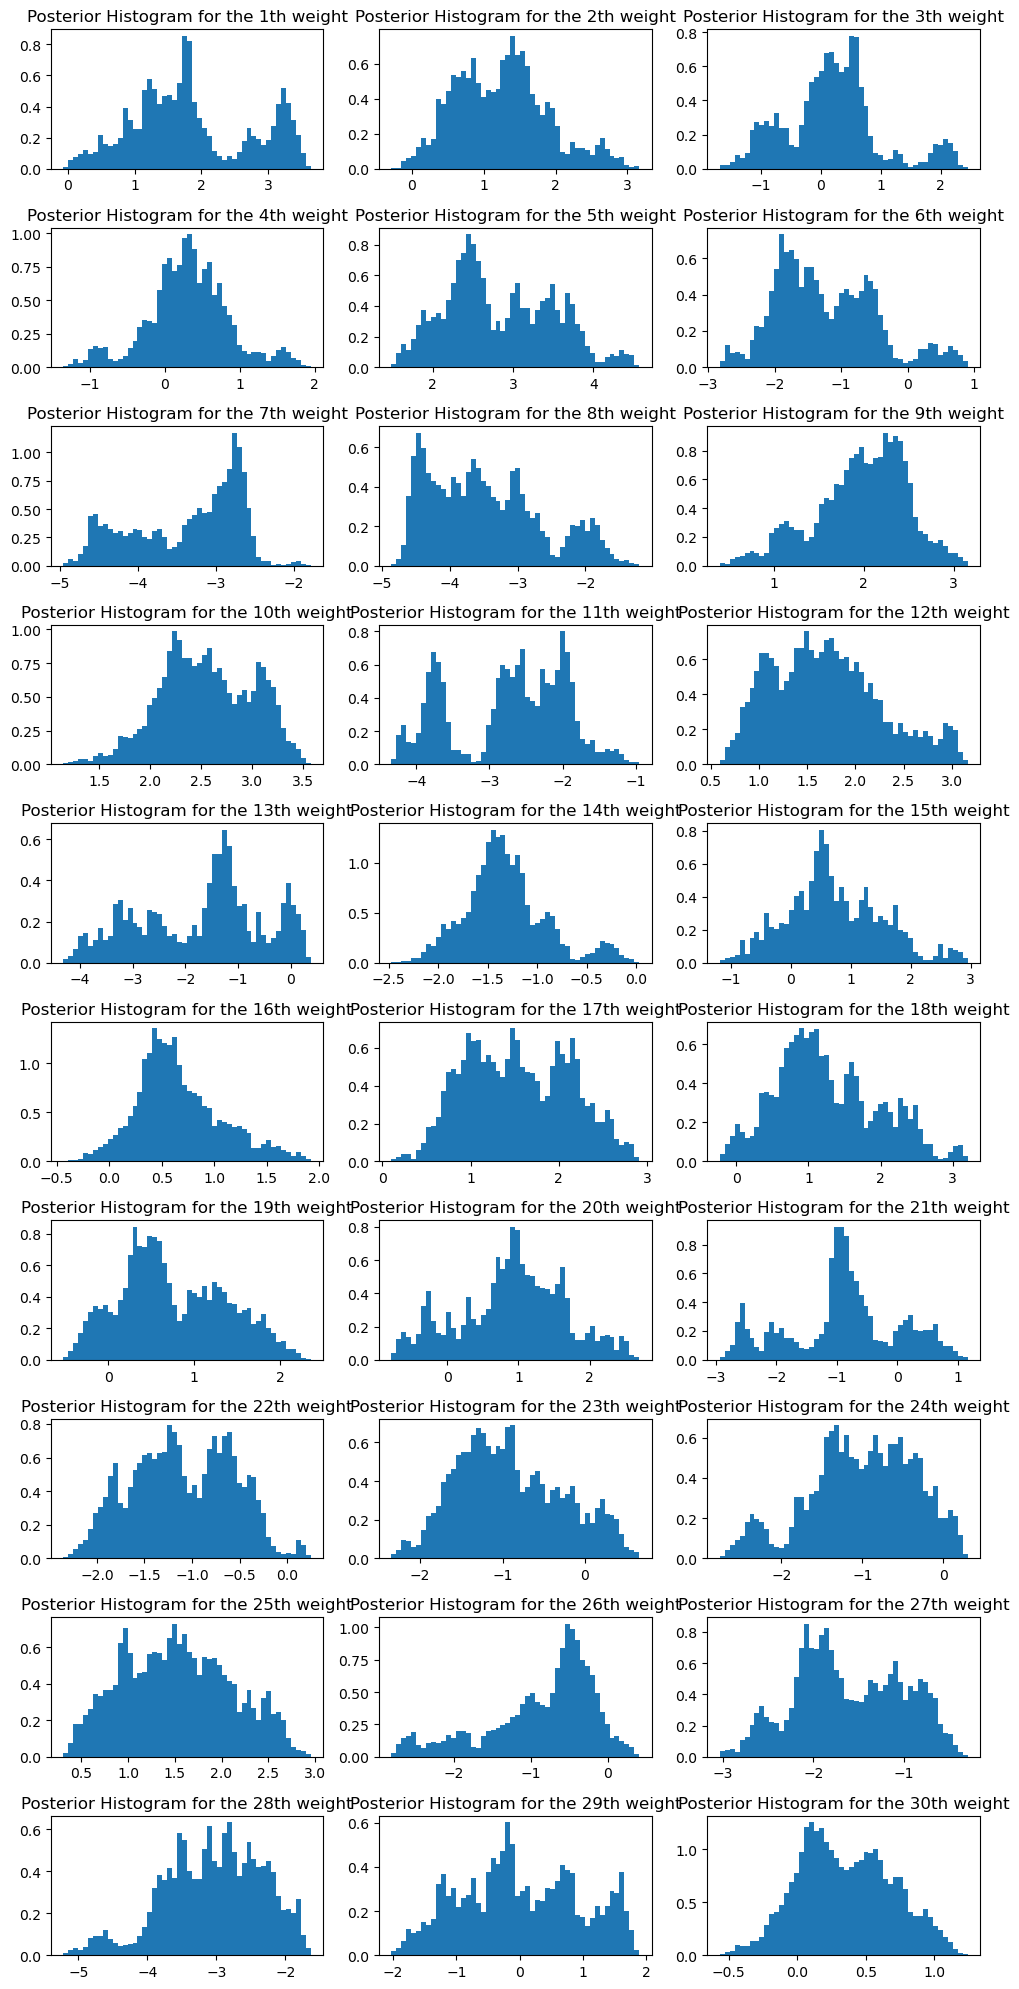

In [49]:
# Create a figure and subplots
fig, axs = plt.subplots(10, 3, figsize=(10, 20))

# Flatten the axs array to make it easier to work with
axs = axs.flatten()

# Plot each curve in its respective subplot
for i in range(d):
    ax = axs[i]
    ax.hist(theta1[int(K/10):K, i],density=True, bins=50, label="Langevin")
    ax.set_title(f"Posterior Histogram for the {i+1}th weight")
    #mean = theta1.mean(axis = 0)[i]
    #ax.text( mean, 50, f'Mean = {mean:.2f}', fontsize=12, ha='center', va='bottom')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [50]:
# Assuming you have your test data in X_test and true labels in Y_test
# Predict labels using posterior samples
predicted_labels = predict_posterior_samples(theta1, X)

# Compute accuracy
accuracy = np.mean(predicted_labels == y)
print("Accuracy:", accuracy)

Accuracy: 0.9050966608084359


## 4.5 Comparison between SVGD and Langevin for Artificial Data

In [51]:
### add code here